# Historical Aution State Classifier

### The goal:

we take 3 inputs:
From prior session (D-1)
	•	VAH₋₁
	•	VAL₋₁
	•	POC₋₁
From current session (D)
	•	Session open price
	•	Time-ordered price bars (fixed interval)



and give up 2 outputs:
   State
        balance
        attempted_breakout up
        attempted_breakout down
        discovery up
        discovery down
   Segment


we're deliberately ignoring:
	•	Developing value
	•	Volume delta
	•	VWAP
	•	Multi-day context
	•	News
	•	Volatility

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf


In [127]:
def get_data(ticker, period, interval):
    
    #############################
    # input: ticker and interval
    # output: return
    
    ticker = yf.Ticker(str(ticker))
    data = ticker.history(period = str(period), interval = str(interval))
    return data

data = get_data(ticker = '^GSPC', period = 'max', interval = '5m') # ^GSPC is the ticker for the S&P 500

In [ ]:
# one day, if we can calculate the value area for one, we can make a function to do it for them all. 
df = data.head(78)[['High','Low']].copy()


In [131]:
df['High'] = df['High'].astype(int)
df['Low'] = df['Low'].astype(int)

In [196]:
# Get TPO for the day.
count = pd.DataFrame( columns=['count'])

for row in df.iterrows():
    for i in range(row[1]['Low'], row[1]['High']):
       count.loc[i] = count['count'].get(i, 0) + 1
count.reset_index(inplace=True)
#count['cumsum'] = count['count'].cumsum()
total = count['count'].sum()
POC = count[count['count']==count['count'].max()]


In [198]:
POC

,index,count
60,6823,26


In [197]:
count

,index,count
0,6766,4
1,6767,4
2,6768,4
3,6769,4
4,6770,4
...,...,...
61,6824,19
62,6825,10
63,6826,9
64,6827,7


In [199]:
# for each poc, we try to calculate the Value Area, and find the smallest range. 
required_count = total * 0.7
VAH = count.index[-1]
VAL = count.index[0]
for poc in POC.index:
    tempVAH = poc
    tempVAL = poc
    countsize = count.loc[poc]['count']
    while countsize < required_count:
        lower = count.loc[tempVAL-1]['count'] if tempVAL > count.index[0] else -1
        upper = count.loc[tempVAH+1]['count'] if tempVAH < count.index[-1] else -1
        # making sure we don't go out of bounds
        if countsize >= required_count: 
            break
        
        if lower > upper:
            countsize += lower
            tempVAL -= 1
        elif upper > lower:
            countsize += upper
            tempVAH += 1
        else:
            if lower != -1:
                countsize += lower
                tempVAL -= 1
            elif upper != -1:
                countsize += upper
                tempVAH += 1

    if tempVAH-tempVAL < VAH-VAL:
        VAH = tempVAH
        VAL = tempVAL

print(VAH, VAL)        



65 30


# FINAL DAILY VALUE AREA CALCULATION FUNCTION:

In [205]:

def getValueArea(df:pd.DataFrame):
    """
    retuns the ltp values that are at the value area low and value area high, along with the POC. 
    args:
        df: dataframe that contains 5m ohlcv data for 1 day
    returns:
    {valueLow, valuehigh, POC,POCs}
    """
    output = {}
    # book keeping
    df['High'] = df['High'].astype(int)
    df['Low'] = df['Low'].astype(int)
    
    # Get TPO for the day.
    count = pd.DataFrame( columns=['count'])
    for row in df.iterrows():
        for i in range(row[1]['Low'], row[1]['High']):
            count.loc[i] = count['count'].get(i, 0) + 1
    count.sort_index(inplace=True)
    count.reset_index(inplace=True)
    total = count['count'].sum()
    POC = count[count['count']==count['count'].max()]
    output['POCs'] = POC

    required_count = total * 0.7
    VAH = len(count)-1
    VAL = 0
    for poc in POC.index:

        tempVAH = poc
        tempVAL = poc
        countsize = count.loc[poc]['count']
        while countsize < required_count:
            # we need to get the next smaller index value. 
            
            lower = count.loc[tempVAL-1]['count'] if tempVAL > count.index[0] else -1
            upper = count.loc[tempVAH+1]['count'] if tempVAH < count.index[-1] else -1
            # making sure we don't go out of bounds

            if countsize >= required_count: 
                break
            
            if lower > upper:
                countsize += lower
                tempVAL -= 1
            elif upper > lower:
                countsize += upper
                tempVAH += 1
            else: # if upper and lower count are equal, expand on boths sides # QUESTION why?
                if upper == -1:
                    countsize += lower
                    tempVAL -= 1
                elif lower == -1:
                    countsize += upper
                    tempVAH += 1
                else:
                    countsize += lower
                    tempVAL -= 1
                    countsize += upper
                    tempVAH += 1

        if tempVAH-tempVAL < VAH-VAL:
            output['VAH'] = count.iloc[tempVAH]['index']
            output['VAL'] = count.iloc[tempVAL]['index']
            VAH = tempVAH
            VAL = tempVAL
            output['POC'] = count.iloc[poc]
    return output
getValueArea(df)
    

{'POCs':     index  count
 60   6823     26,
 'VAH': np.int64(6828),
 'VAL': np.int64(6793),
 'POC': index    6823
 count      26
 Name: 60, dtype: int64}

# CLASSIFICATION

now that we have the value area of the previous day, we can proceed to classify the auction contidion of the present day.

(np.float64(6576.95), np.float64(6666.05))


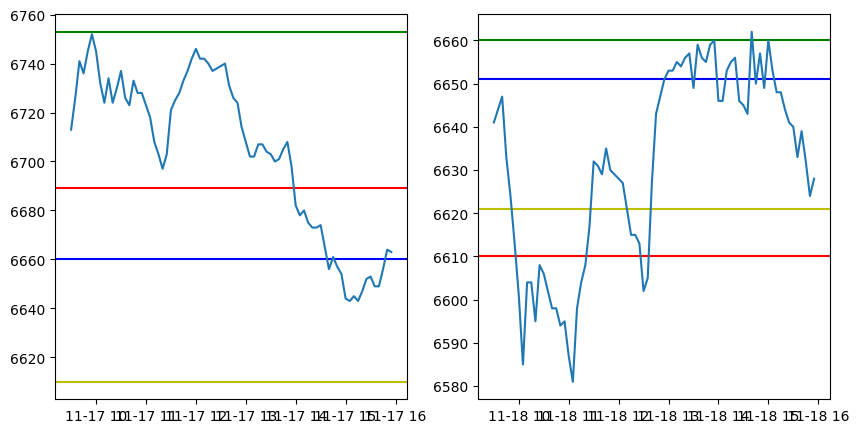

In [289]:
day = 9
prev_day = data.iloc[(day-1)*78:day*78].drop(columns=['Volume','Dividends','Stock Splits']).astype(int)
current_day = data.iloc[day*78:(day+1)*78].drop(columns=['Volume','Dividends','Stock Splits']).astype(int)
valueArea_params = getValueArea(prev_day)
valueArea_params_curr = getValueArea(current_day)
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].axhline(y=valueArea_params['VAH'], color='g')
ax[0].axhline(y=valueArea_params['VAL'], color='r')
ax[0].axhline(y=valueArea_params_curr['VAH'], color='b')
ax[0].axhline(y=valueArea_params_curr['VAL'], color='y')
ax[0].plot(prev_day['Open'])

next_day = data.iloc[(day+1)*78:(day+2)*78].drop(columns=['Volume','Dividends','Stock Splits']).astype(int)

valueArea_params_next = getValueArea(next_day)


ax[1].axhline(y=valueArea_params_curr['VAH'], color='g')
ax[1].axhline(y=valueArea_params_curr['VAL'], color='r')
ax[1].axhline(y=valueArea_params_next['VAH'], color='b')
ax[1].axhline(y=valueArea_params_next['VAL'], color='y')
ax[1].plot(current_day['Open'])
print(plt.ylim())
plt.show()

In [ ]:
day = 8
prev_day = data.iloc[(day-1)*78:day*78].drop(columns=['Volume','Dividends','Stock Splits']).astype(int)
current_day = data.iloc[day*78:(day+1)*78].drop(columns=['Volume','Dividends','Stock Splits']).astype(int)
valueArea_params = getValueArea(prev_day)
valueArea_params_curr = getValueArea(current_day)
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].axhline(y=valueArea_params['VAH'], color='g')
ax[0].axhline(y=valueArea_params['VAL'], color='r')
ax[0].axhline(y=valueArea_params_curr['VAH'], color='b')
ax[0].axhline(y=valueArea_params_curr['VAL'], color='y')
ax[0].plot(prev_day['Open'])

{'POCs':      index  count
 113   6759     20,
 'VAH': np.int64(6771),
 'VAL': np.int64(6726),
 'POC': index    6759
 count      20
 Name: 113, dtype: int64}

In [276]:
valueArea_params

{'POCs':     index  count
 13   6737     17
 17   6741     17
 18   6742     17,
 'VAH': np.int64(6778),
 'VAL': np.int64(6724),
 'POC': index    6737
 count      17
 Name: 13, dtype: int64}

#### REVIEW OF THE RULES:

1. Balance

2. Attempted Breakout

3. Discovery

we'll just classify the day. based on hard coded rules. 

>n bars outside close/open: discovery
less than n bars outside close/open: attemptted breakout
all bars inside close/open: balance 

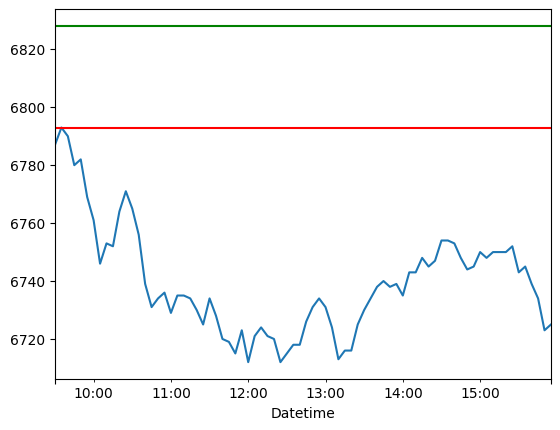